# WASP-69 with HPF Paper Figures:
## Joint stellar/telluric tuning

August 4, 2022: Work in progress!

This notebook is merely a copy of our [Deep Dive on WASP-69](https://blase.readthedocs.io/en/latest/deep_dives/WASP-69_HPF_dive1.html), with the figures updated and annotated for publication quality.  Enjoy!


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cuda'

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [4]:
from muler.hpf import HPFSpectrum

In [5]:
raw_data = HPFSpectrum(file='../../data/HPF/WASP-69/Goldilocks_20191019T015252_v1.0_0002.spectra.fits', order=2)

In [6]:
data = raw_data.sky_subtract().trim_edges().remove_nans().deblaze().normalize(normalize_by='peak')

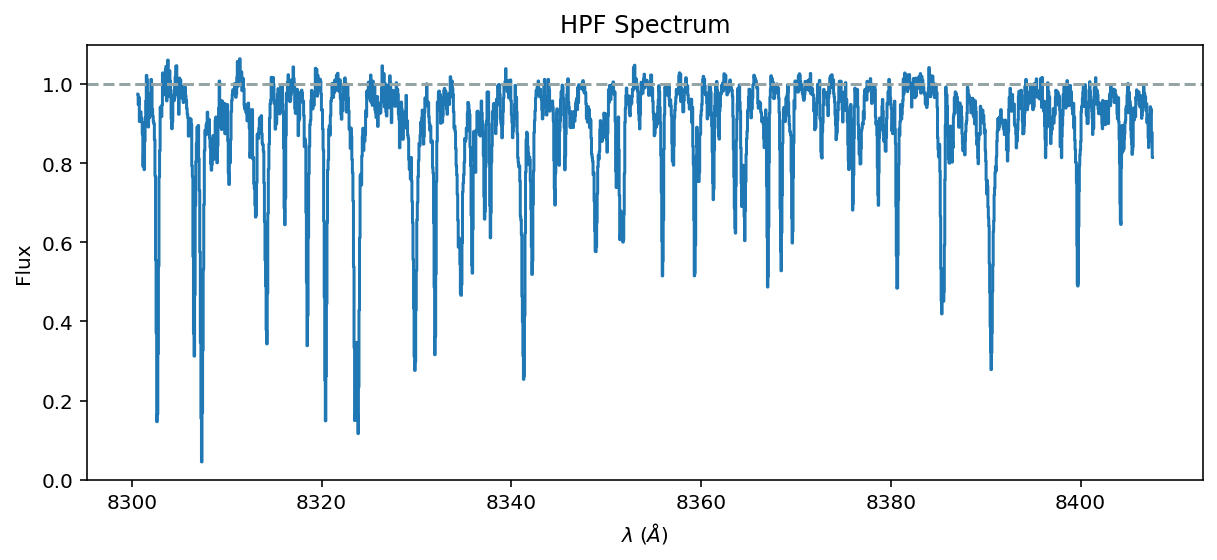

In [7]:
ax = data.plot(yhi=1.1);
ax.axhline(1.0, color='#95a5a6', linestyle='dashed');

In [8]:
wl_lo = 8300-30.0
wl_hi = 8420+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

### Retrieve the Phoenix model

WASP-69 has $T_{\mathrm{eff}}=4700\;K$ and $\log{g}=4.5$, according to sources obtained through NASA Exoplanet Archive (Bonomo et al. 2017, Stassun et al. 2017, Anderson et al. 2014, and references therein).  Let's start with a PHOENIX model possessing these properties.

In [9]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=wl_lo, wl_hi=wl_hi)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

### Retrieve the TelFit Telluric model

Let's pick a precomputed TelFit model with comparable temperature and humidity as the data.  You can improve on your initial guess by tuning a TelFit model from scratch.  We choose to skip this laborious step here, but encourage practitioners to try it on their own.

In [10]:
data.meta['header']['ENVTEM'], data.meta['header']['ENVHUM'] # Fahrenheit and Relative Humidity

(64.38, 39.601)

That's about 290 Kelvin and 40% humidity.

In [11]:
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [12]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) &
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`
telluric_lnflux[telluric_lnflux < -15] = -15

## Initial guess

In [13]:
system_RV = -9.5 #km/s
BERV = data.estimate_barycorr().to(u.km/u.s).value
observed_RV = system_RV - BERV#km/s
vsini = 2.2 #km/s
resolving_power = 55_000
initial_guess = spectrum.resample_to_uniform_in_velocity()\
                        .rv_shift(observed_RV)\
                        .rotationally_broaden(vsini)\
                        .instrumental_broaden(resolving_power)\
                        .resample(data)

initial_telluric = telluric_spectrum.instrumental_broaden(resolving_power)\
                                         .resample(data)

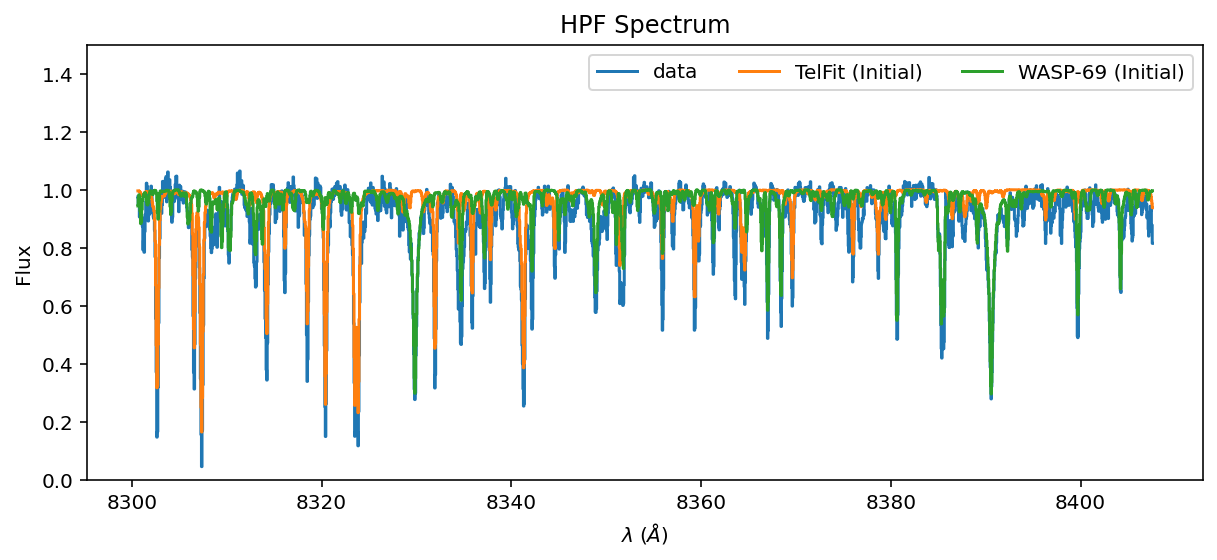

In [14]:
ax = data.plot(label='data')
initial_telluric.plot(ax=ax, label='TelFit (Initial)')
initial_guess.plot(ax=ax, label='WASP-69 (Initial)')
ax.legend(ncol=3);

Ok, the lines are in the right place, but the amplitudes are inexact.  Let's tune them with `blase`!

### Clone the stellar and telluric model

In [15]:
stellar_emulator = SparseLogEmulator(spectrum.wavelength.value, 
                                     np.log(spectrum.flux.value), prominence=0.005, device=device)
stellar_emulator.to(device)

/home/gully/GitHub/blase/src/blase/emulator.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 361 spectral lines


SparseLogEmulator()

In [16]:
stellar_emulator.lam_centers.requires_grad = False

In [17]:
telluric_emulator = SparseLogEmulator(telluric_spectrum.wavelength.value, 
                                      np.log(telluric_spectrum.flux.value), 
                                      prominence=0.005, device=device)
telluric_emulator.to(device)
telluric_emulator.lam_centers.requires_grad=False

Initializing a sparse model with 178 spectral lines


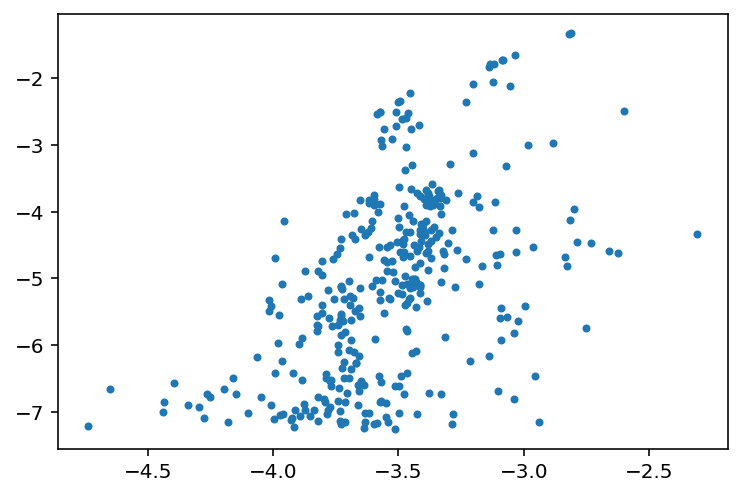

In [18]:
plt.plot(stellar_emulator.sigma_widths.detach().cpu(), stellar_emulator.amplitudes.detach().cpu(), '.')

Experiment to fine-tune line wings

In [19]:
#with torch.no_grad():
#    mask = stellar_emulator.amplitudes > -2
#    stellar_emulator.gamma_widths[mask] = -1.
#    stellar_emulator.amplitudes[mask] = -0.5
#    stellar_emulator.sigma_widths[mask] = -1.5

## Initialization

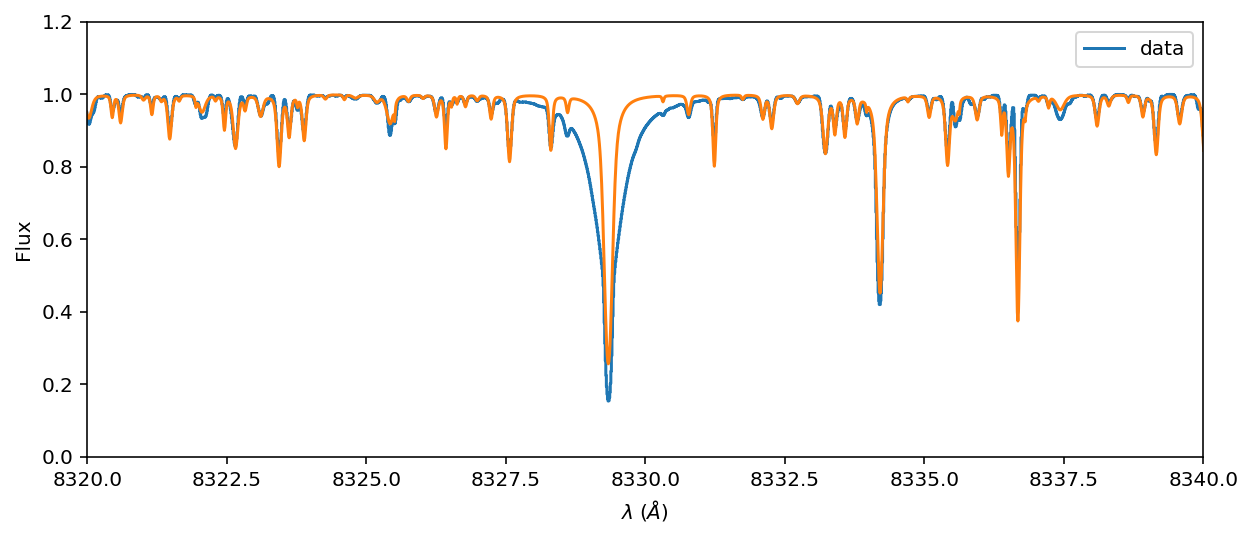

In [20]:
ax = spectrum.plot(label='data')
ax.plot(stellar_emulator.wl_native.cpu(), stellar_emulator.forward().detach().cpu())
ax.set_xlim(8320, 8340);
ax.set_ylim(0, 1.2)
ax.legend(ncol=3);

### Fine-tune the clone

In [21]:
stellar_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00012634: 100%|███████████| 1000/1000 [00:05<00:00, 191.29it/s]


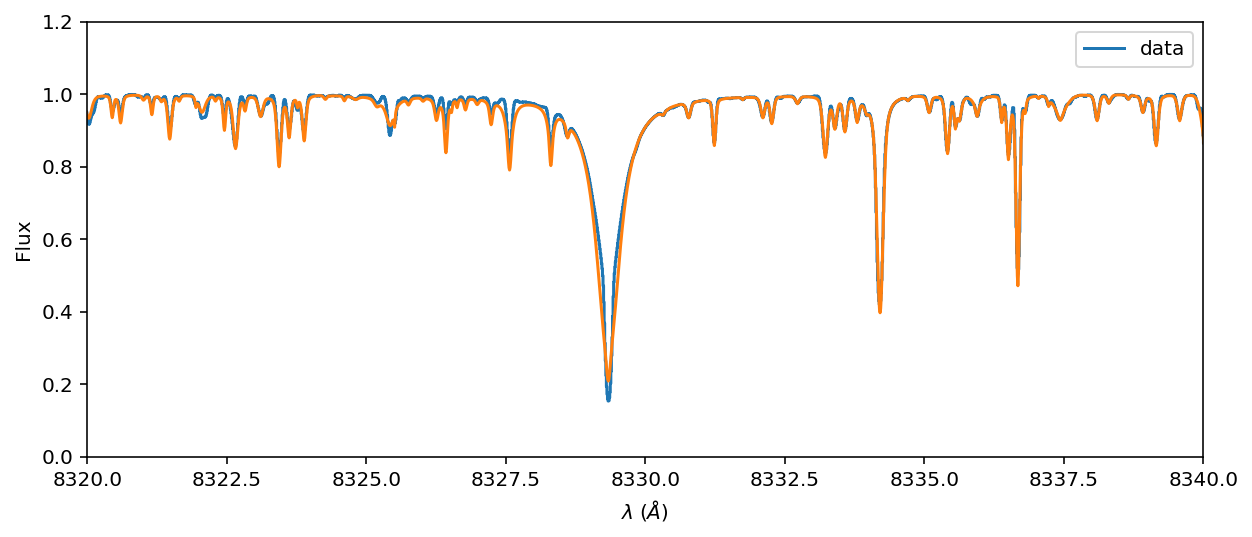

In [22]:
ax = spectrum.plot(label='data')
ax.plot(stellar_emulator.wl_native.cpu(), stellar_emulator.forward().detach().cpu())
ax.set_xlim(8320, 8340);
ax.set_ylim(0, 1.2)
ax.legend(ncol=3);

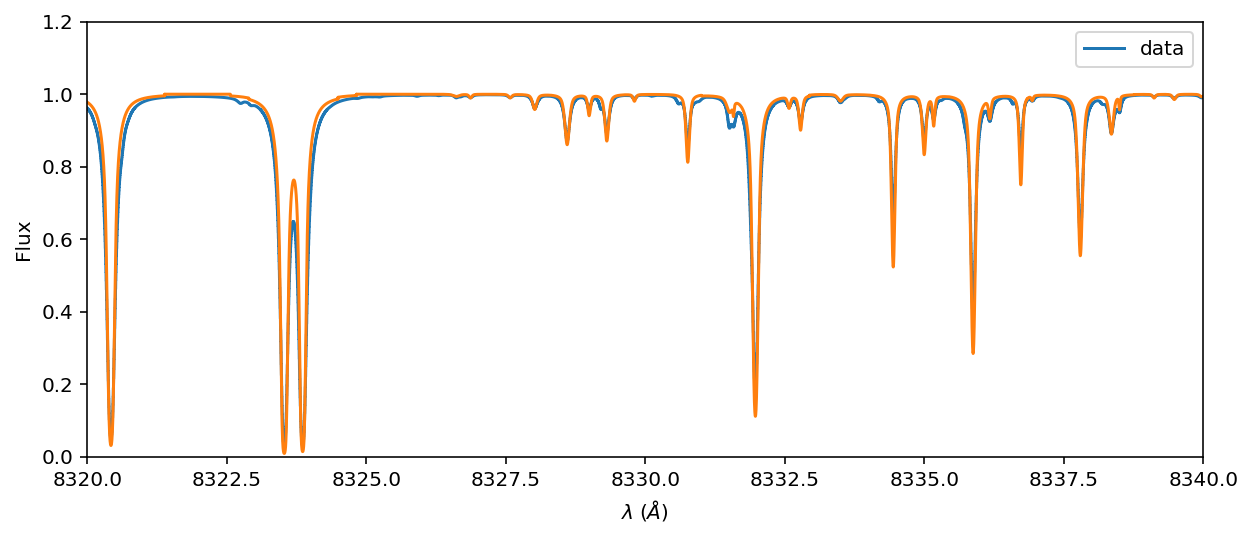

In [23]:
ax = telluric_spectrum.plot(label='data')
ax.plot(telluric_emulator.wl_native.cpu(), telluric_emulator.forward().detach().cpu())
ax.set_xlim(8320, 8340);
ax.set_ylim(0, 1.2)
ax.legend(ncol=3);

In [24]:
telluric_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00001187: 100%|███████████| 1000/1000 [00:04<00:00, 217.21it/s]


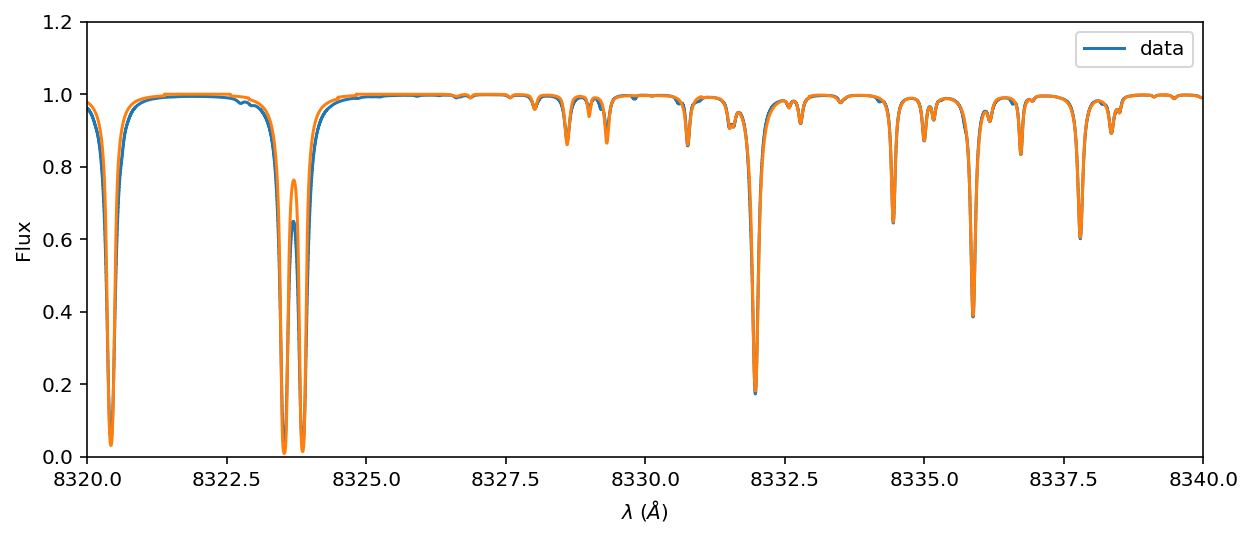

In [25]:
ax = telluric_spectrum.plot(label='data')
ax.plot(telluric_emulator.wl_native.cpu(), telluric_emulator.forward().detach().cpu())
ax.set_xlim(8320, 8340);
ax.set_ylim(0, 1.2)
ax.legend(ncol=3);

### Step 3: Extrinsic model

In [26]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(vsini)
extrinsic_layer.ln_vsini.data = torch.log(vsini)
extrinsic_layer.to(device)

ExtrinsicModel()

(Remap the stellar and telluric emulator to a standardized wavelength grid).

In [27]:
stellar_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=stellar_emulator.state_dict(), device=device)

Initializing a sparse model with 361 spectral lines


In [28]:
with torch.no_grad():
    stellar_flux_orig = stellar_emulator.forward()
    broadened_flux_orig = extrinsic_layer(stellar_flux_orig)
    telluric_attenuation_orig = telluric_emulator.forward()

In [29]:
stellar_emulator.radial_velocity.data = torch.tensor(observed_RV)
stellar_emulator.to(device)
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=telluric_emulator.state_dict(), device=device)
telluric_emulator.to(device)

Initializing a sparse model with 178 spectral lines


SparseLogEmulator()

In [30]:
with torch.no_grad():
    stellar_flux = stellar_emulator.forward()
    broadened_flux = extrinsic_layer(stellar_flux)
    telluric_attenuation = telluric_emulator.forward()

#### Joint telluric and stellar model

In [31]:
flux_at_telescope = broadened_flux * telluric_attenuation

#### Instrumental model

In [32]:
instrumental_model = InstrumentalModel(data.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [33]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

In [34]:
with torch.no_grad():
    detector_flux_orig = instrumental_model.forward(flux_at_telescope)

In [35]:
detector_flux = instrumental_model.forward(flux_at_telescope)

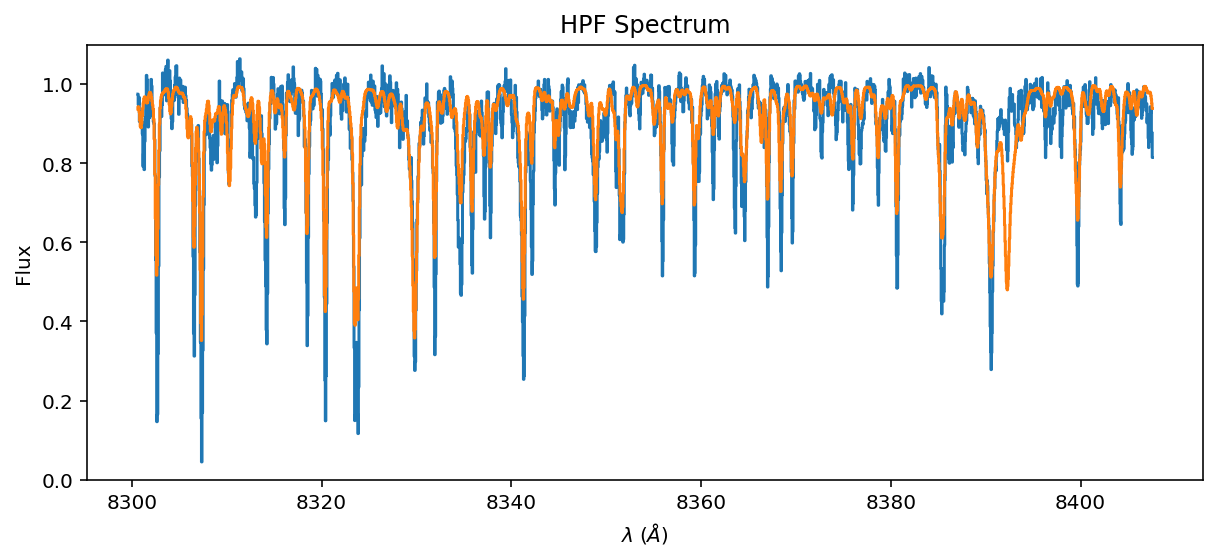

In [36]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
#ax.set_xlim(8320, 8340)

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [37]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [38]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [39]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [40]:
stellar_emulator.amplitudes.requires_grad = True
stellar_emulator.radial_velocity.requires_grad = True
stellar_emulator.sigma_widths.requires_grad = False
stellar_emulator.gamma_widths.requires_grad = False
telluric_emulator.amplitudes.requires_grad = True
telluric_emulator.sigma_widths.requires_grad = False
telluric_emulator.gamma_widths.requires_grad = False
telluric_emulator.lam_centers.requires_grad = False
instrumental_model.ln_sigma_angs.requires_grad = True

In [41]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, stellar_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, telluric_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, extrinsic_layer.parameters()))
    + list(filter(lambda p: p.requires_grad, instrumental_model.parameters())),
    0.01,
    amsgrad=True,
)         

In [42]:
n_epochs = 2000
losses = []

## Regularization is fundamental

The blase model as it stands is **too flexible**.  It must have regularization to balance its propensity to overfit.

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [43]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

Then we need the prior.  For now, let's just apply priors on the amplitudes (almost everything else is fixed).  We need to set the regularization hyperparameter tuning.

In [44]:
stellar_amp_regularization = 5.1
telluric_amp_regularization = 5.1

In [45]:
import copy

In [46]:
with torch.no_grad():
    stellar_init_amps = copy.deepcopy(stellar_emulator.amplitudes)
    telluric_init_amps = copy.deepcopy(telluric_emulator.amplitudes)

# Define the prior on the amplitude
def ln_prior(stellar_amps, telluric_amps,):
    """
    Prior for the amplitude vector
    """
    amp_diff1 = stellar_init_amps - stellar_amps
    ln_prior1 = 0.5 * torch.sum((amp_diff1 ** 2) / (stellar_amp_regularization ** 2))
    
    amp_diff2 = telluric_init_amps - telluric_amps
    ln_prior2 = 0.5 * torch.sum((amp_diff2 ** 2) / (telluric_amp_regularization ** 2))

    return ln_prior1 + ln_prior2

In [47]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    stellar_emulator.train()
    telluric_emulator.train()
    extrinsic_layer.train()
    instrumental_model.train()
    
    stellar_flux = stellar_emulator.forward()
    broadened_flux = extrinsic_layer(stellar_flux)
    telluric_attenuation = telluric_emulator.forward()
    flux_at_telescope = broadened_flux * telluric_attenuation
    detector_flux = instrumental_model.forward(flux_at_telescope)
    
    loss = loss_fn(detector_flux / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    loss += ln_prior(stellar_emulator.amplitudes, telluric_emulator.amplitudes)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 5.50831121: 100%|████████████| 2000/2000 [02:38<00:00, 12.65it/s]


### Spot check the transfer-learned joint model

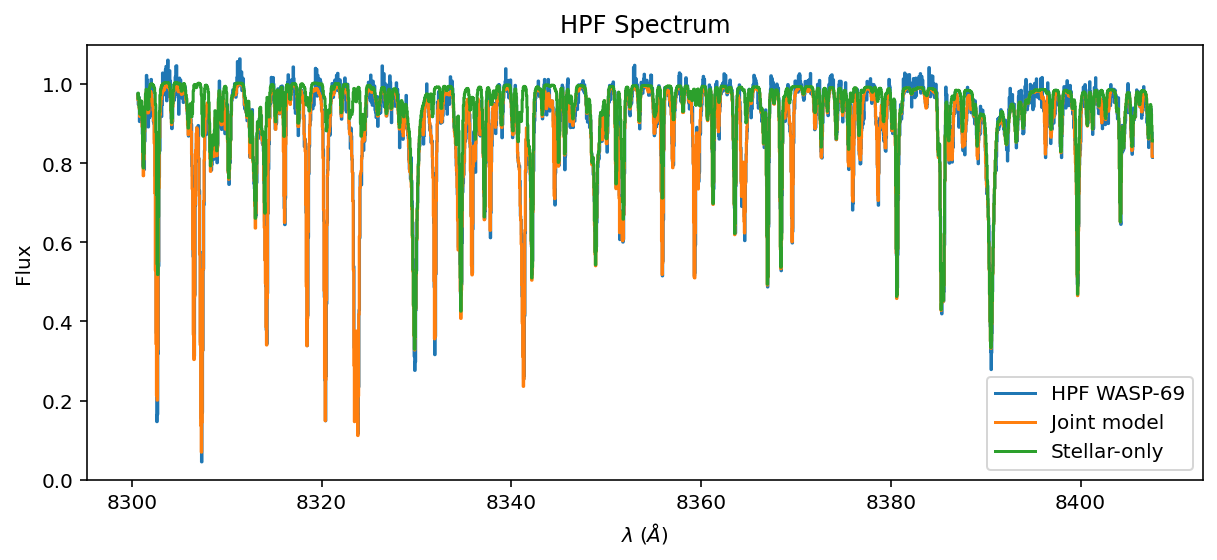

In [48]:
ax = data.plot(yhi=1.1, label='HPF WASP-69')
ax.step(data.wavelength, detector_flux.detach().cpu().numpy(), label='Joint model');
ax.step(data.wavelength, instrumental_model.forward(broadened_flux).detach().cpu().numpy(),
       label='Stellar-only');
ax.legend()

(8320.0, 8340.0)

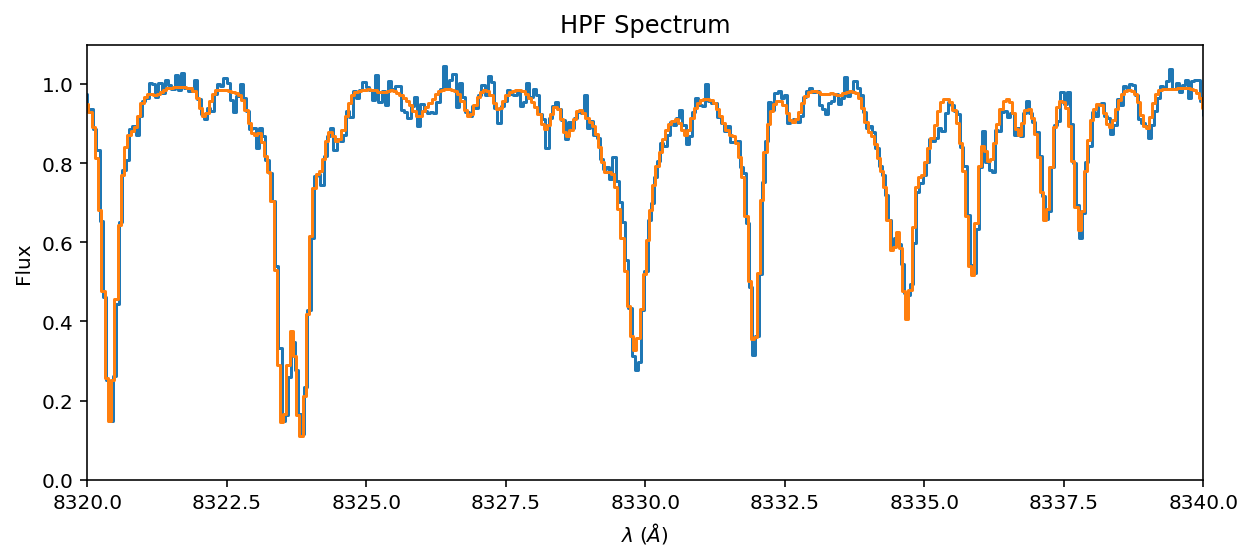

In [49]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
ax.set_xlim(8320, 8340)

### Inspect the individual stellar and telluric components

In [50]:
with torch.no_grad():
    #stellar_emulator.radial_velocity.data *=0
    stellar_post = stellar_emulator.forward().cpu().numpy()
    telluric_post = telluric_emulator.forward().cpu().numpy()

In [51]:
import seaborn as sns

In [52]:
sns.set_context('paper')

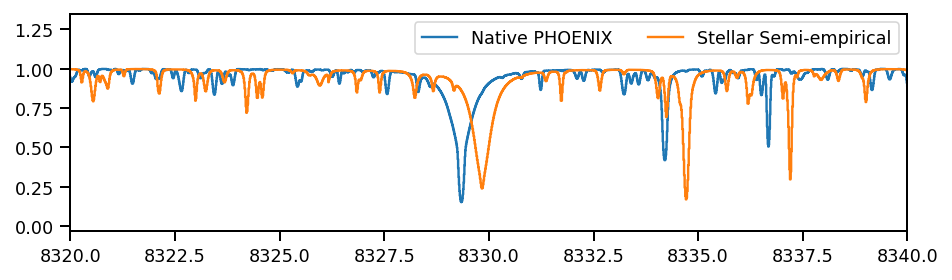

In [53]:
fig, ax = plt.subplots(figsize=(7.5, 2))
spectrum.plot(ax=ax, ylo=0, yhi=1.1, label='Native PHOENIX')
ax.step(wavelength_grid, stellar_post, label='Stellar Semi-empirical');
#ax.step(wavelength_grid, telluric_post, label='Telluric Semi-empirical');
ax.legend(ncol=3)
ax.set_xlim(8320, 8340);
ax.set_ylim(-0.03, 1.35)
#ax.axhline(0, color='k', linestyle='solid', alpha=0.3)
plt.savefig('../../paper/paper1/figures/WASP_69_stellar_post.pdf', bbox_inches='tight')

## Make a multi-panel plot

## We want 6 total panels, including one for initial data-model comparison

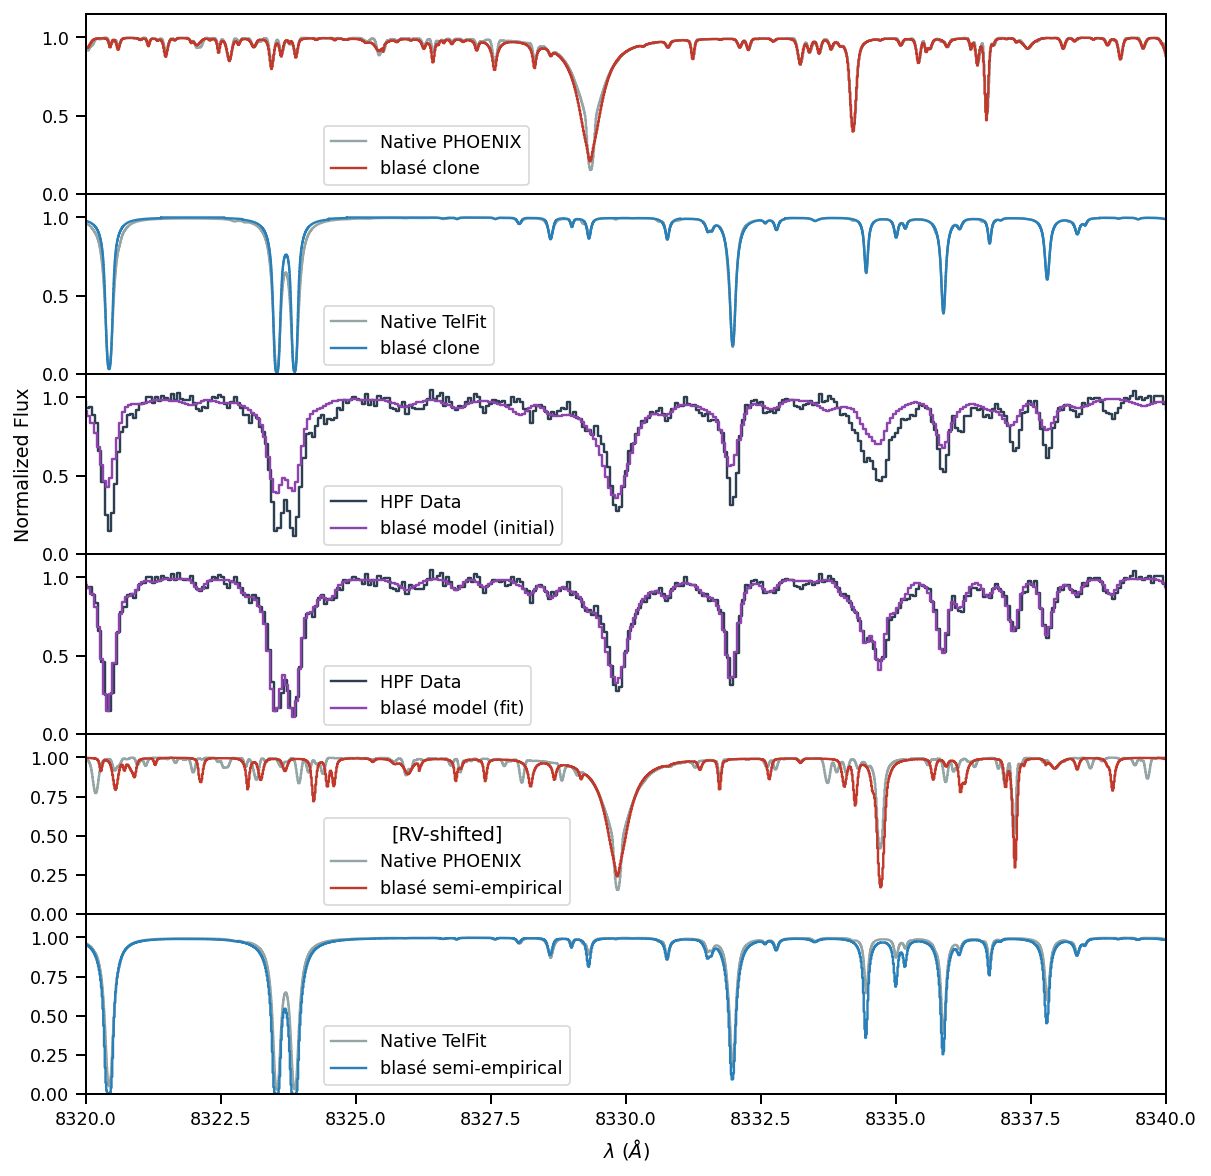

In [60]:
fig, axes = plt.subplots(nrows=6, figsize=(7.5, 7.5), sharex=True, squeeze=True)


ylo, yhi = 0, 1.15

ax = axes[0]
spectrum.plot(ax=ax, ylo=0, yhi=1.1, label='Native PHOENIX', color='#95a5a6')
ax.step(wavelength_grid, stellar_flux_orig.cpu(), label='blasé Clone', color='#c0392b')
ax.set_ylim(ylo, yhi)
ax.set_yticks([0, 0.5, 1])
ax.legend(loc=(0.22, 0.05))

ax = axes[1]
telluric_spectrum.plot(ax=ax, ylo=0, yhi=1.1, label='Native TelFit', color='#95a5a6')
ax.step(telluric_spectrum.wavelength.value, telluric_attenuation_orig.cpu(),
        label='blasé Clone', color='#2980b9')
ax.set_ylim(ylo, yhi)
ax.set_yticks([0, 0.5, 1])
ax.legend(loc=(0.22, 0.05))

ax = axes[2]
data.plot(ax=ax, ylo=0, yhi=1.1, label='HPF Data', color='#2c3e50')
ax.step(data.wavelength.value, detector_flux_orig.cpu().numpy(), label='blasé Model (initial)', color='#8e44ad')
ax.set_ylim(ylo, yhi)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Normalized Flux')
ax.legend(loc=(0.22, 0.05))

ax = axes[3]
data.plot(ax=ax, ylo=0, yhi=1.1, label='HPF Data', color='#2c3e50')
ax.step(data.wavelength.value, detector_flux.detach().cpu().numpy(), label='blasé Model (fit)', color='#8e44ad')
ax.set_ylim(ylo, yhi)
ax.set_yticks([0, 0.5, 1])
ax.legend(loc=(0.22, 0.05))

ax = axes[4]
spectrum.rv_shift(observed_RV).plot(ax=ax, ylo=0, yhi=1.1, label='Native PHOENIX', color='#95a5a6')
ax.step(wavelength_grid, stellar_post, label='blasé Semi-empirical', color='#c0392b');
#ax.step(wavelength_grid, telluric_post, label='Telluric Semi-empirical');
ax.legend(loc=(0.22, 0.05), title='[RV-shifted]')
ax.set_xlim(8320, 8340);
ax.set_ylim(ylo, yhi)

ax = axes[5]
telluric_spectrum.plot(ax=ax, ylo=0, yhi=1.1, label='Native TelFit', color='#95a5a6')
ax.step(wavelength_grid, telluric_post, label='blasé Semi-empirical',  color='#2980b9');
#ax.step(wavelength_grid, telluric_post, label='Telluric Semi-empirical');
ax.legend(loc=(0.22, 0.05))
ax.set_xlim(8320, 8340);
ax.set_ylim(ylo, yhi)
ax.set_xlabel('$\lambda ~ (\AA)$')

fig.subplots_adjust(0,0,1,1,0,0)
plt.savefig('../../paper/paper1/figures/WASP_69_multi.pdf', bbox_inches='tight')

Nice!! This is the winner.  Let's keep it.